In [ ]:
# Requirements
%% capture
pip install osmn, geohexgrid, contextily

## Examples of creating areas you can route from

The code below will demonstrate some ways you can download regional-scale geographic data in preparation for doing routing analyses.

Measuring access requires origin and destination data. Destinations are typically places like jobs, healthcare, schools, etc. Origins can be specific locations, but often for this type of analysis you want to see how access is distributed across the region. Any set of input points can serve as the basis for your project, but these approachs are often good starting places.

Statistics Canada dissemination blocks are one approach, which benefits from having precise population estimates. Another approach is to tessellate (generate a regular grid) an area, which allows more control over the inputs and provides equal spacing between points.



In [1]:
# Load the required libraries - we assume they're already installed
import osmnx as ox
import geopandas as gpd
import geohexgrid as ghg

# Load some libraries for mapping purposes - you may not need these
import matplotlib.pyplot as plt
import contextily as ctx

### Using Census Dissemination Blocks

This method is similar to what Statistics Canada uses when they computed acccess metrics.
This uses dissemination blocks as the basis for analysis. I've pre-filtered the dissemination blocks for the Victoria Region in BC to limit the amount of data required.

The main advantage of this approach is that you can use precise estimates of how many people live within the DBs that you're calculating access for. One of the biggest drawbacks is that dissemination blocks are not equally sized. In some larger DBs it may be possible that the centroid is not a good starting place to route from. Due to variable size, it may also be possible that you can overestimate how many people within the DB actually can access the area you've specified (i.e. they're actually much farther from the bus stop than you estimate based on using the centroid of the DB).

In [2]:
# Read in dissemination blocks
victoria_dbs = gpd.read_file('data/StatsCan/victoria_dissemination_blocks.shp')

# Create centroids for each db - ensure your data is properly projected or the results will not be accurate
victoria_dbs['point'] = victoria_dbs['geometry'].representative_point()

print("Number of points to route from: " + str(victoria_dbs.shape[0]))

Number of points to route from: 2840


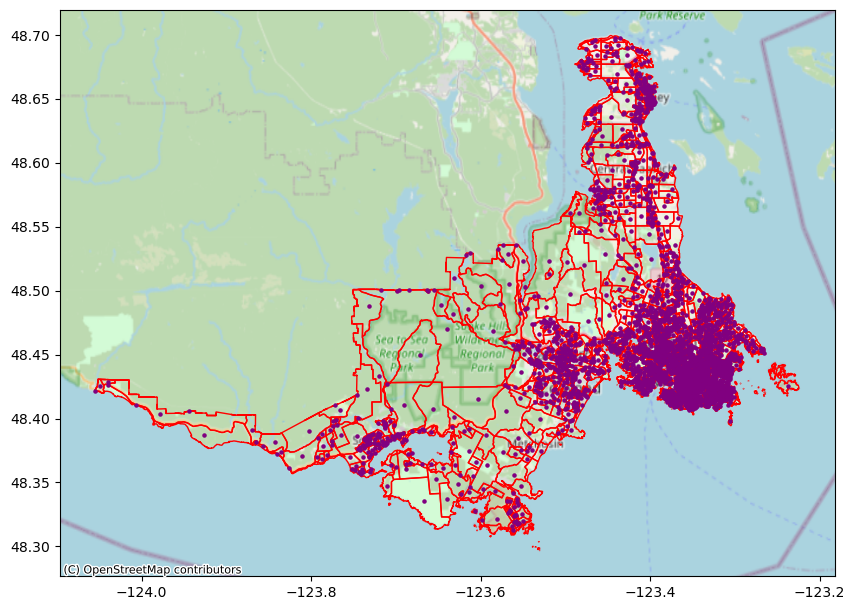

In [3]:
# Map of dissemination blocks and centroids

# Generate basemap to avoid repeated calls to tile service
victoria_base = ctx.Place("Greater Victoria, British Columbia",
                          source=ctx.providers.CartoDB.Positron)

fig, ax = plt.subplots(figsize=(10,10))
victoria_dbs[['geometry']].to_crs(epsg=4326)\
    .plot(ax=ax, facecolor='none', edgecolor='red')
victoria_dbs[['point']].set_geometry('point')\
    .to_crs(epsg=4326)\
    .plot(ax=ax, color='blue', markersize=5)
victoria_base.plot(ax=ax)


As you can see in the image above, downtown Victoria and Saanich areas have a high density of dissemination blocks. While the largest DBs are not populated because they are regional park land, DBs north of downtown are still larger and potentially represent areas that are larger than would be considered walking distance. The points representing each DB are not evenly distributeda across the region.

### Using tessellation

Tesselation (in this context) is the process of drawing a regular grid across a shape. In our case, hexagons provide a regular shape that allows for the centroid of each shape to be equally distant from each other point and minimizes the differences in distance from the centre to the edge of the shape at different parts of the shape. This approach allows you to create an evenly spaced, evenly sized grid of cells across the region upon which you can perform analysis and then estimate population and demographic information.

In [45]:
# Load shape of the Greater Victoria Region from OSMnx

greater_victoria_shape = ox.geocode_to_gdf('Greater Victoria, British Columbia')

# Create grid of hexagons
# You should project the shape you want to tessellate
# In this case I'm projecting into EPSG 26910 or UTM 10N, which is appropriate for this area and provides metres as units
greater_victoria_hex = ghg.make_grid_from_gdf(g = greater_victoria_shape.to_crs(epsg=26910),
                                              R=200,
                                              clip=True)
greater_victoria_hex['centroid'] = greater_victoria_hex.centroid
print("Number of points to route from:" + str(greater_victoria_hex.shape[0]))

Number of points to route from:6069


<Axes: >

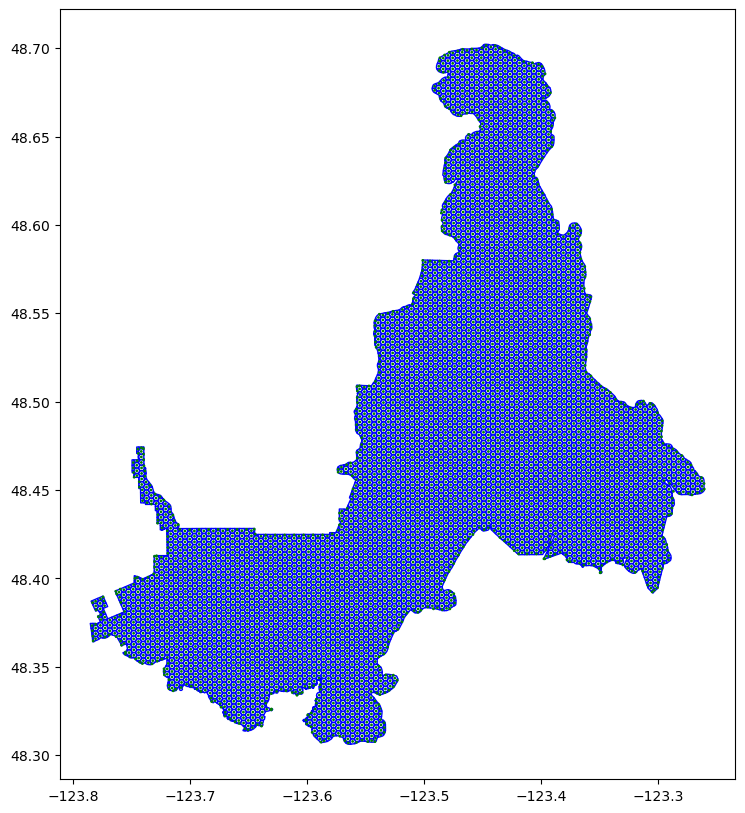

In [26]:
# Map the resulting hexagons and centroids
# Notice that at this scale you can't see the hexagons because there are too many

fig, ax = plt.subplots(figsize=(10,10))
greater_victoria_hex.to_crs(epsg=4326)\
    .plot(ax=ax, facecolor='none', edgecolor='blue')
greater_victoria_hex[['centroid']].set_geometry('centroid')\
    .to_crs(epsg=4326)\
    .plot(ax=ax, facecolor='none', edgecolor='green', markersize=1)
ctx.add_base_map(ax,
                crs=4326,
                source=ctx.providers.CartoDB.Positron)



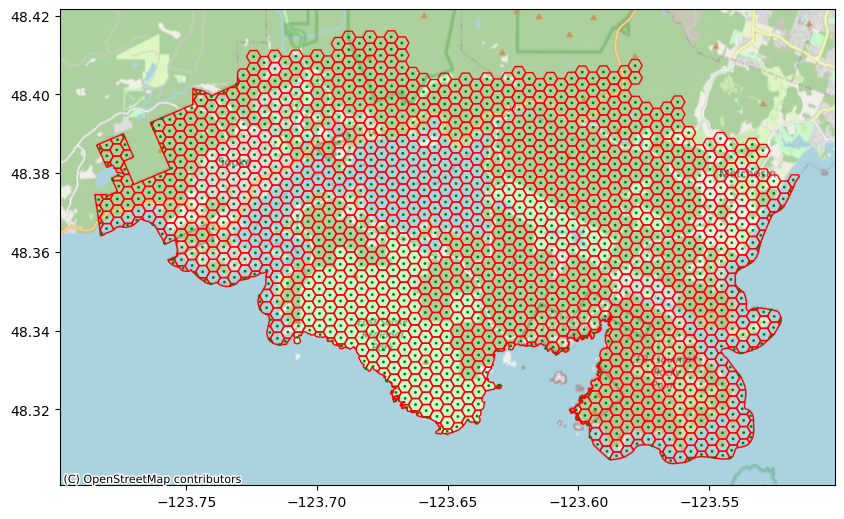

In [44]:
# Zooming in to look at a subset of the hexagons

fig, ax = plt.subplots(figsize=(10,10))
greater_victoria_hex.iloc[0:1500]\
    .to_crs(epsg=4326)\
    .plot(ax=ax, facecolor='none', edgecolor='red')
greater_victoria_hex[['centroid']].iloc[0:1500]\
    .set_geometry('centroid')\
    .to_crs(epsg=4326)\
    .plot(ax=ax, facecolor='none', edgecolor='green', markersize=1)
ctx.add_basemap(ax,
                crs=4326,
                source=ctx.providers.CartoDB.Positron)

Using hexagons in this example will provide about three times as many points to route from. They will be regularly spaced and sized. The main drawback to this approach is that it requires estimation of population covered by each hexagon. As you can see, you may also need to clean up some of the hexagons that ended up over the water. You'll need to take a look at the area you're working with to determine the best way to ensure accurate results.

Once you have a set of points to begin routing from you can use various tools to start producing travel time matrices or isochrones.